In [1]:
import os
import argparse
import logging
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--network', type=str, choices=['resnet', 'odenet'], default='odenet')
parser.add_argument('--tol', type=float, default=1e-3)
parser.add_argument('--adjoint', type=eval, default=False, choices=[True, False])
parser.add_argument('--downsampling-method', type=str, default='conv', choices=['conv', 'res'])
parser.add_argument('--nepochs', type=int, default=160)
parser.add_argument('--data_aug', type=eval, default=True, choices=[True, False])
parser.add_argument('--lr', type=float, default=0.1)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--test_batch_size', type=int, default=1000)

parser.add_argument('--save', type=str, default='./experiment1')
parser.add_argument('--debug', action='store_true')
parser.add_argument('--gpu', type=int, default=0)

_StoreAction(option_strings=['--gpu'], dest='gpu', nargs=None, const=None, default=0, type=<class 'int'>, choices=None, help=None, metavar=None)

In [3]:
args = parser.parse_args([])

In [4]:
from torchdiffeq import odeint_adjoint as odeint

In [5]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


def norm(dim):
    return nn.GroupNorm(min(32, dim), dim)


class ResBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.norm1 = norm(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.norm2 = norm(planes)
        self.conv2 = conv3x3(planes, planes)

    def forward(self, x):
        shortcut = x

        out = self.relu(self.norm1(x))

        if self.downsample is not None:
            shortcut = self.downsample(out)

        out = self.conv1(out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(out)

        return out + shortcut

In [6]:
class ConcatConv2d(nn.Module):

    def __init__(self, dim_in, dim_out, ksize=3, stride=1, padding=0, dilation=1, groups=1, bias=True, transpose=False):
        super(ConcatConv2d, self).__init__()
        module = nn.ConvTranspose2d if transpose else nn.Conv2d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size=ksize, stride=stride, padding=padding, dilation=dilation, groups=groups,
            bias=bias
        )

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :, :]) * t
        ttx = torch.cat([tt, x], 1)
        return self._layer(ttx)

In [7]:
class ODEfunc(nn.Module):

    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 = norm(dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm2 = norm(dim)
        self.conv2 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm3 = norm(dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.norm1(x)
        out = self.relu(out)
        out = self.conv1(t, out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(t, out)
        out = self.norm3(out)
        return out

In [8]:
class ODEBlock(nn.Module):

    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, rtol=args.tol, atol=args.tol)
        return out[1]

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value

In [9]:
class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

In [10]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()
        self.values = []

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val
        self.values.append(val)


def get_mnist_loaders(data_aug=False, batch_size=128, test_batch_size=1000, perc=1.0):
    if data_aug:
        transform_train = transforms.Compose([
            transforms.RandomCrop(28, padding=4),
            transforms.ToTensor(),
        ])
    else:
        transform_train = transforms.Compose([
            transforms.ToTensor(),
        ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_loader = DataLoader(
        datasets.MNIST(root='.data/mnist', train=True, download=True, transform=transform_train), batch_size=batch_size,
        shuffle=True, num_workers=2, drop_last=True
    )

    train_eval_loader = DataLoader(
        datasets.MNIST(root='.data/mnist', train=True, download=True, transform=transform_test),
        batch_size=test_batch_size, shuffle=False, num_workers=2, drop_last=True
    )

    test_loader = DataLoader(
        datasets.MNIST(root='.data/mnist', train=False, download=True, transform=transform_test),
        batch_size=test_batch_size, shuffle=False, num_workers=2, drop_last=True
    )

    return train_loader, test_loader, train_eval_loader


def inf_generator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, (x, y) in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()


def learning_rate_with_decay(batch_size, batch_denom, batches_per_epoch, boundary_epochs, decay_rates):
    initial_learning_rate = args.lr * batch_size / batch_denom

    boundaries = [int(batches_per_epoch * epoch) for epoch in boundary_epochs]
    vals = [initial_learning_rate * decay for decay in decay_rates]

    def learning_rate_fn(itr):
        lt = [itr < b for b in boundaries] + [True]
        i = np.argmax(lt)
        return vals[i]

    return learning_rate_fn


def one_hot(x, K):
    return np.array(x[:, None] == np.arange(K)[None, :], dtype=int)


def accuracy(model, dataset_loader):
    total_correct = 0
    for x, y in dataset_loader:
        x = x.to(device)
        y = one_hot(np.array(y.numpy()), 10)

        target_class = np.argmax(y, axis=1)
        predicted_class = np.argmax(model(x).cpu().detach().numpy(), axis=1)
        total_correct += np.sum(predicted_class == target_class)
    return total_correct / len(dataset_loader.dataset)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)


def get_logger(logpath, package_files=[], displaying=True, saving=True, debug=False):
    logger = logging.getLogger()
    if debug:
        level = logging.DEBUG
    else:
        level = logging.INFO
    logger.setLevel(level)
    if saving:
        info_file_handler = logging.FileHandler(logpath, mode="a")
        info_file_handler.setLevel(level)
        logger.addHandler(info_file_handler)
    if displaying:
        console_handler = logging.StreamHandler()
        console_handler.setLevel(level)
        logger.addHandler(console_handler)
    for f in package_files:
        logger.info(f)
        with open(f, "r") as package_f:
            logger.info(package_f.read())
    return logger

In [11]:
makedirs(args.save)
logger = get_logger(logpath=os.path.join(args.save, 'logs'))
logger.info(args)

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

is_odenet = args.network == 'odenet'

Namespace(adjoint=False, batch_size=128, data_aug=True, debug=False, downsampling_method='conv', gpu=0, lr=0.1, nepochs=160, network='odenet', save='./experiment1', test_batch_size=1000, tol=0.001)


In [12]:
if args.downsampling_method == 'conv':
    downsampling_layers = [
        nn.Conv2d(1, 64, 3, 1),
        norm(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, 4, 2, 1),
        norm(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, 4, 2, 1),
    ]
elif args.downsampling_method == 'res':
    downsampling_layers = [
        nn.Conv2d(1, 64, 3, 1),
        ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
        ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
    ]
feature_layers = [ODEBlock(ODEfunc(64))] if is_odenet else [ResBlock(64, 64) for _ in range(6)]
fc_layers = [norm(64), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Linear(64, 10)]
model = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers).to(device)

logger.info(model)
logger.info('Number of parameters: {}'.format(count_parameters(model)))

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): GroupNorm(32, 64, eps=1e-05, affine=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): GroupNorm(32, 64, eps=1e-05, affine=True)
  (5): ReLU(inplace)
  (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (7): ODEBlock(
    (odefunc): ODEfunc(
      (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu): ReLU(inplace)
      (conv1): ConcatConv2d(
        (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv2): ConcatConv2d(
        (_layer): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norm3): GroupNorm(32, 64, eps=1e-05, affine=True)
    )
  )
  (8): GroupNorm(32, 64, eps=1e-05, affine=True)
  (9): ReLU(inplace)
  (10): AdaptiveAvgPool2d(output_size=(1, 1))
  (11): Flatten()
  (12): Linear(in_fe

In [13]:
criterion = nn.CrossEntropyLoss().to(device)

train_loader, test_loader, train_eval_loader = get_mnist_loaders(
    args.data_aug, args.batch_size, args.test_batch_size
)

data_gen = inf_generator(train_loader)
batches_per_epoch = len(train_loader)

lr_fn = learning_rate_with_decay(
    args.batch_size, batch_denom=128, batches_per_epoch=batches_per_epoch, boundary_epochs=[60, 100, 140],
    decay_rates=[1, 0.1, 0.01, 0.001]
)

optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)

try :
    checkpoint = torch.load(os.path.join(args.save, 'model.pth'))
    model.load_state_dict(checkpoint['state_dict'])
except FileNotFoundError :
    pass

In [14]:
best_acc = 0
batch_time_meter = RunningAverageMeter()
f_nfe_meter = RunningAverageMeter()
b_nfe_meter = RunningAverageMeter()
end = time.time()

In [15]:
for itr in range(args.nepochs * batches_per_epoch):

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_fn(itr)

    optimizer.zero_grad()
    x, y = data_gen.__next__()
    x = x.to(device)
    y = y.to(device)
    logits = model(x)
    loss = criterion(logits, y)

    if is_odenet:
        nfe_forward = feature_layers[0].nfe
        feature_layers[0].nfe = 0

    loss.backward()
    optimizer.step()

    if is_odenet:
        nfe_backward = feature_layers[0].nfe
        feature_layers[0].nfe = 0

    batch_time_meter.update(time.time() - end)
    if is_odenet:
        f_nfe_meter.update(nfe_forward)
        b_nfe_meter.update(nfe_backward)
    end = time.time()

    if itr % batches_per_epoch == 0:
        with torch.no_grad():
            train_acc = accuracy(model, train_eval_loader)
            val_acc = accuracy(model, test_loader)
            if val_acc > best_acc:
                torch.save({'state_dict': model.state_dict(), 'args': args}, os.path.join(args.save, 'model.pth'))
                best_acc = val_acc
            logger.info(
                "Epoch {:04d} | Time {:.3f} ({:.3f}) | NFE-F {:.1f} | NFE-B {:.1f} | "
                "Train Acc {:.4f} | Test Acc {:.4f}".format(
                    itr // batches_per_epoch, batch_time_meter.val, batch_time_meter.avg, f_nfe_meter.avg,
                    b_nfe_meter.avg, train_acc, val_acc
                )
            )

Epoch 0000 | Time 0.485 (0.485) | NFE-F 32.0 | NFE-B 39.0 | Train Acc 0.0986 | Test Acc 0.0958
Epoch 0001 | Time 0.235 (0.194) | NFE-F 20.3 | NFE-B 23.8 | Train Acc 0.9781 | Test Acc 0.9818
Epoch 0002 | Time 0.266 (0.191) | NFE-F 20.1 | NFE-B 23.7 | Train Acc 0.9899 | Test Acc 0.9921
Epoch 0003 | Time 0.282 (0.189) | NFE-F 20.1 | NFE-B 23.2 | Train Acc 0.9911 | Test Acc 0.9907
Epoch 0004 | Time 0.235 (0.178) | NFE-F 20.1 | NFE-B 21.4 | Train Acc 0.9872 | Test Acc 0.9856
Epoch 0005 | Time 0.235 (0.178) | NFE-F 20.2 | NFE-B 21.1 | Train Acc 0.9938 | Test Acc 0.9935
Epoch 0006 | Time 0.238 (0.177) | NFE-F 20.1 | NFE-B 21.1 | Train Acc 0.9920 | Test Acc 0.9915
Epoch 0007 | Time 0.242 (0.177) | NFE-F 20.1 | NFE-B 21.0 | Train Acc 0.9938 | Test Acc 0.9936
Epoch 0008 | Time 0.238 (0.177) | NFE-F 20.2 | NFE-B 21.0 | Train Acc 0.9892 | Test Acc 0.9905
Epoch 0009 | Time 0.243 (0.179) | NFE-F 20.6 | NFE-B 21.0 | Train Acc 0.9935 | Test Acc 0.9906
Epoch 0010 | Time 0.241 (0.179) | NFE-F 21.1 | NFE

Epoch 0087 | Time 0.250 (0.192) | NFE-F 26.2 | NFE-B 21.1 | Train Acc 0.9999 | Test Acc 0.9958
Epoch 0088 | Time 0.249 (0.192) | NFE-F 26.2 | NFE-B 21.2 | Train Acc 0.9999 | Test Acc 0.9962
Epoch 0089 | Time 0.256 (0.191) | NFE-F 26.2 | NFE-B 21.2 | Train Acc 0.9999 | Test Acc 0.9960
Epoch 0090 | Time 0.250 (0.192) | NFE-F 26.2 | NFE-B 21.2 | Train Acc 0.9999 | Test Acc 0.9958
Epoch 0091 | Time 0.250 (0.193) | NFE-F 26.2 | NFE-B 21.3 | Train Acc 0.9999 | Test Acc 0.9956
Epoch 0092 | Time 0.249 (0.194) | NFE-F 26.2 | NFE-B 21.6 | Train Acc 0.9999 | Test Acc 0.9959
Epoch 0093 | Time 0.252 (0.196) | NFE-F 26.2 | NFE-B 21.9 | Train Acc 0.9999 | Test Acc 0.9957
Epoch 0094 | Time 0.279 (0.195) | NFE-F 26.2 | NFE-B 21.9 | Train Acc 0.9999 | Test Acc 0.9962
Epoch 0095 | Time 0.257 (0.196) | NFE-F 26.2 | NFE-B 22.1 | Train Acc 0.9999 | Test Acc 0.9960
Epoch 0096 | Time 0.249 (0.201) | NFE-F 26.2 | NFE-B 23.1 | Train Acc 0.9999 | Test Acc 0.9957
Epoch 0097 | Time 0.284 (0.198) | NFE-F 26.2 | NFE

In [16]:
args.tol = 1e-2
with torch.no_grad():
    end = time.time()
    val_acc = accuracy(model, test_loader)
    if is_odenet:
        nfe_forward = feature_layers[0].nfe
        feature_layers[0].nfe = 0
    dt = time.time()-end
    logger.info(
        "Test with {:.4f} tolerance | Time {:.3f} ({:.3f}) | NFE-F {:.1f} ({:.3f}) | Test Acc {:.4f}".format(
            args.tol, dt, dt/len(test_loader), nfe_forward, nfe_forward/len(test_loader), val_acc
        )
    )

Test with 0.0100 tolerance | Time 4.360 (0.436) | NFE-F 200.0 (20.000) | Test Acc 0.9958


In [17]:
args.tol = 1e-4
with torch.no_grad():
    end = time.time()
    val_acc = accuracy(model, test_loader)
    if is_odenet:
        nfe_forward = feature_layers[0].nfe
        feature_layers[0].nfe = 0
    dt = time.time()-end
    logger.info(
        "Test with {:.4f} tolerance | Time {:.3f} ({:.3f}) | NFE-F {:.1f} ({:.3f}) | Test Acc {:.4f}".format(
            args.tol, dt, dt/len(test_loader), nfe_forward, nfe_forward/len(test_loader), val_acc
        )
    )

Test with 0.0001 tolerance | Time 7.641 (0.764) | NFE-F 380.0 (38.000) | Test Acc 0.9959


In [18]:
args.tol = 1e-1
with torch.no_grad():
    end = time.time()
    val_acc = accuracy(model, test_loader)
    if is_odenet:
        nfe_forward = feature_layers[0].nfe
        feature_layers[0].nfe = 0
    dt = time.time()-end
    logger.info(
        "Test with {:.4f} tolerance | Time {:.3f} ({:.3f}) | NFE-F {:.1f} ({:.3f}) | Test Acc {:.4f}".format(
            args.tol, dt, dt/len(test_loader), nfe_forward, nfe_forward/len(test_loader), val_acc
        )
    )

Test with 0.1000 tolerance | Time 3.333 (0.333) | NFE-F 140.0 (14.000) | Test Acc 0.9957


In [19]:
args.tol = 1e-0
with torch.no_grad():
    end = time.time()
    val_acc = accuracy(model, test_loader)
    if is_odenet:
        nfe_forward = feature_layers[0].nfe
        feature_layers[0].nfe = 0
    dt = time.time()-end
    logger.info(
        "Test with {:.4f} tolerance | Time {:.3f} ({:.3f}) | NFE-F {:.1f} ({:.3f}) | Test Acc {:.4f}".format(
            args.tol, dt, dt/len(test_loader), nfe_forward, nfe_forward/len(test_loader), val_acc
        )
    )

Test with 1.0000 tolerance | Time 3.313 (0.331) | NFE-F 140.0 (14.000) | Test Acc 0.9960


In [22]:
%matplotlib notebook

<IPython.core.display.Javascript object>


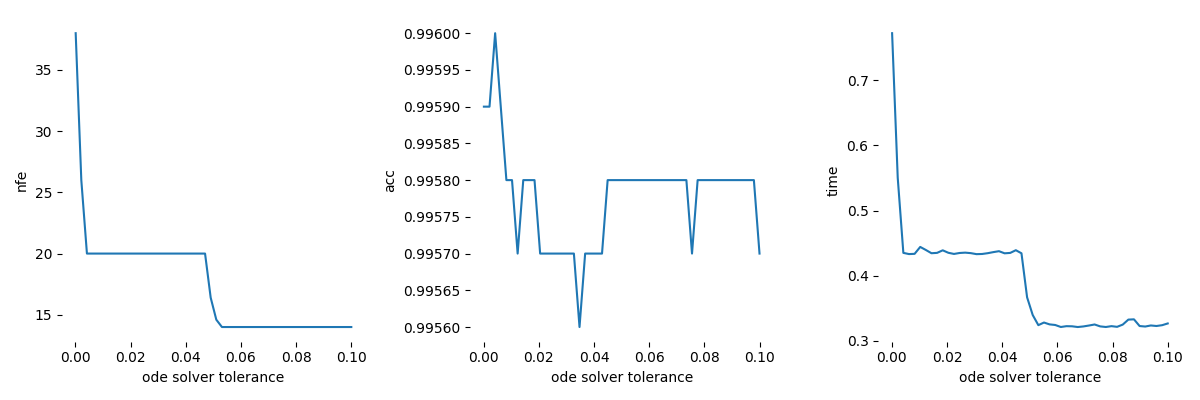

Test with 0.0001 tolerance | Time 7.724 (0.772) | NFE-F 380.0 (38.000) | Test Acc 0.9959
Test with 0.0021 tolerance | Time 5.504 (0.550) | NFE-F 260.0 (26.000) | Test Acc 0.9959
Test with 0.0042 tolerance | Time 4.350 (0.435) | NFE-F 200.0 (20.000) | Test Acc 0.9960
Test with 0.0062 tolerance | Time 4.332 (0.433) | NFE-F 200.0 (20.000) | Test Acc 0.9959
Test with 0.0083 tolerance | Time 4.335 (0.434) | NFE-F 200.0 (20.000) | Test Acc 0.9958
Test with 0.0103 tolerance | Time 4.442 (0.444) | NFE-F 200.0 (20.000) | Test Acc 0.9958
Test with 0.0123 tolerance | Time 4.395 (0.439) | NFE-F 200.0 (20.000) | Test Acc 0.9957
Test with 0.0144 tolerance | Time 4.345 (0.434) | NFE-F 200.0 (20.000) | Test Acc 0.9958
Test with 0.0164 tolerance | Time 4.350 (0.435) | NFE-F 200.0 (20.000) | Test Acc 0.9958
Test with 0.0184 tolerance | Time 4.390 (0.439) | NFE-F 200.0 (20.000) | Test Acc 0.9958
Test with 0.0205 tolerance | Time 4.352 (0.435) | NFE-F 200.0 (20.000) | Test Acc 0.9957
Test with 0.0225 tole

In [26]:
import matplotlib.pyplot as plt
class KVPlotter() :
    def __init__(self, nrows, ncols, **kwargs) :
        self.fig = plt.figure(figsize=(12, 4), facecolor='white')
        self.axis = [self.fig.add_subplot(nrows,ncols,i+1,frameon=False) for i in range(nrows*ncols)]
    def plot(self, keys, values, xlabel='x', ylabel='y', index=0) :
        axis = self.axis[index]
        axis.cla()
        axis.set_xlabel(xlabel)
        axis.set_ylabel(ylabel)
        axis.plot(keys, values)
        self.fig.tight_layout()
        plt.show()
def test(tolerance) :
    args.tol = tolerance
    with torch.no_grad():
        end = time.time()
        val_acc = accuracy(model, test_loader)
        if is_odenet:
            nfe_forward = feature_layers[0].nfe
            feature_layers[0].nfe = 0
        dt = time.time()-end
        logger.info(
            "Test with {:.4f} tolerance | Time {:.3f} ({:.3f}) | NFE-F {:.1f} ({:.3f}) | Test Acc {:.4f}".format(
                args.tol, dt, dt/len(test_loader), nfe_forward, nfe_forward/len(test_loader), val_acc
            )
        )
    return dt, nfe_forward, val_acc, len(test_loader)

# create meter instance
nfe_meter = RunningAverageMeter()
dt_meter = RunningAverageMeter()
acc_meter = RunningAverageMeter()

plotter = KVPlotter(nrows=1, ncols=3)

range_tolerance = np.linspace(1e-4,1e-1,50)
for t in range_tolerance :
    dt, nfe, acc, n = test(t)
    nfe_meter.update(nfe/n)
    dt_meter.update(dt/n)
    acc_meter.update(acc)

plotter.plot(range_tolerance, nfe_meter.values, xlabel='ode solver tolerance', ylabel='nfe', index=0)
plotter.plot(range_tolerance, acc_meter.values, xlabel='ode solver tolerance', ylabel='acc', index=1)
plotter.plot(range_tolerance, dt_meter.values, xlabel='ode solver tolerance', ylabel='time', index=2)